In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from skimage import data, color, exposure, img_as_ubyte, img_as_uint
from satsense.features.hog import hog
from satsense.util import load_from_file, normalize_image, get_rgb_image

# Supported image formats include RGB, Quickbird and Worldview
from satsense.util import RGB, QUICKBIRD, WORLDVIEW2

# URI to the image
imagefile = '/home/bweel/Documents/projects/dynaslum/data/satelite/056239125010_01/056239125010_01_P001_MUL/08NOV02054348-M2AS_R1C1-056239125010_01_P001.TIF'
# Set the correct format here, it is used throughout the notebook
bands = QUICKBIRD

# Loading the file
dataset, image = load_from_file(imagefile)

In [12]:
from skimage.feature import canny

rgb_image = get_rgb_image(image[100:200, 100:200, :], bands)
img = img_as_uint(color.rgb2gray(rgb_image))

/home/bweel/anaconda2/envs/satelite/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [13]:
edges = canny(img, 2, 1, 25)

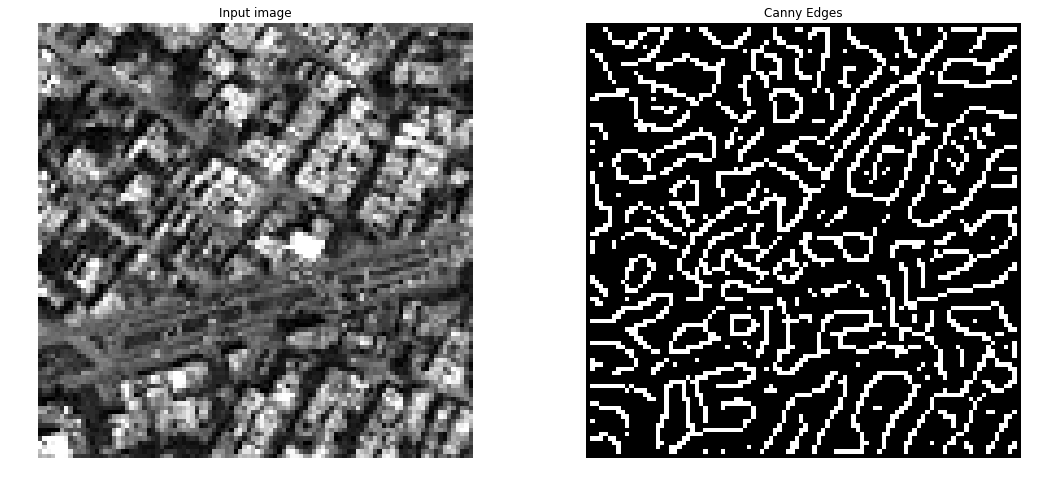

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(edges, cmap = plt.cm.gray)
ax2.set_title('Canny Edges')
ax1.set_adjustable('box-forced')
plt.show()

In [16]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

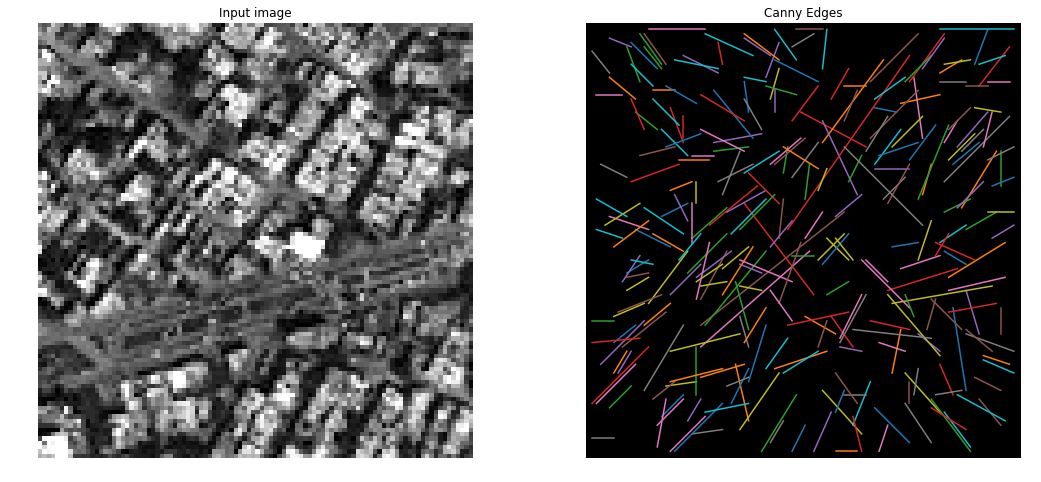

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(edges*0, cmap = plt.cm.gray)
for line in lines:
    p0, p1 = line
    ax2.plot((p0[0], p1[0]), (p0[1], p1[1]))

ax2.set_title('Canny Edges')
ax1.set_adjustable('box-forced')
plt.show()